# Repair WRF wind data

This notebook explores the issue of improperly rotated wind data in the [Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution](http://ckan.snap.uaf.edu/dataset/historical-and-projected-dynamically-downscaled-climate-data-for-the-state-of-alaska-and-surrou) SNAP dataset. It also provides a record of the steps that were taken to rectify the issue. 

**Note (KMR)** - the code cells in this notebook were most recently executed on Atlas in June, 2021.

## Background

This section explores the relevant background of post-processing the raw WRF wind data and making it available on AWS. It attempts to shed light on the current state of things - how and when each set of outputs was generated (because there are duplicate sets of outputs in different locations) - with particular concern for determining the most likely series of events taken for producing the wind data that were previously hosted on AWS, which had the issue of incorrect values.

Note - with ongoing changes to the pipeline structure, this section may become outdated. Notably, the "improvement" step may get wraped into the "re-stacking" step.

### The issue

First, we explore the issue at hand.  

In Dec 2020, Peter B noticed that ERA-Interim wind directions derived from the **production dataset** (the WRF data hosted on AWS) were incorrect. He has provided correctly rotated wind data as a reference, which can be found at: `/workspace/Shared/Tech_Projects/wrf_data/project_data/wind-issue/truth_winds_1980-01-01_00.nc`.

#### Example

Using the truth data that Peter has provided, plot the differences between the truth data and the production data.

**Note (KMR)** - I deleted the production data from AWS and therefore this comparison cannot utilize the *true* production data, e.g. by downloading the problematic files from AWS.

First off, what is the source of the production data - what files were uploaded to AWS? There is really only one candidate, **`/rcs/project_data/wrf_data/hourly_fix/`**, which is referenced in the `wrap_run_move_wrf_aws_s3.py` script (most recent commit with this file occurred on 2019-09-22) that copies files in that directory to the AWS OpenData bucket for hosting.

**Note (KMR)** - I have removed the majority of the incorrect wind data files from `/rcs/project_data/wrf_data/hourly_fix/` to free up space and reduce confusion. I retained a sample of incorrect data in `/rcs/project_data/wrf_data/wind-issue/incorrect_samples` for historical purposes. After removing all files but a sample subset, I moved this subset of remaining files to the samples folder via the following commands:

```
mv /rcs/project_data/wrf_data/hourly_fix/u*/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix
# (note, no other variables present that begin with "u")
mv /rcs/project_data/wrf_data/hourly_fix/v/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix
mv /rcs/project_data/wrf_data/hourly_fix/v10/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix
mv /rcs/project_data/wrf_data/hourly_fix/vbot/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix
```
With the production data identified, here is a visualization of the differences between the truth data and the corresponding data that were in `/rcs/project_data/wrf_data/hourly_fix/`:

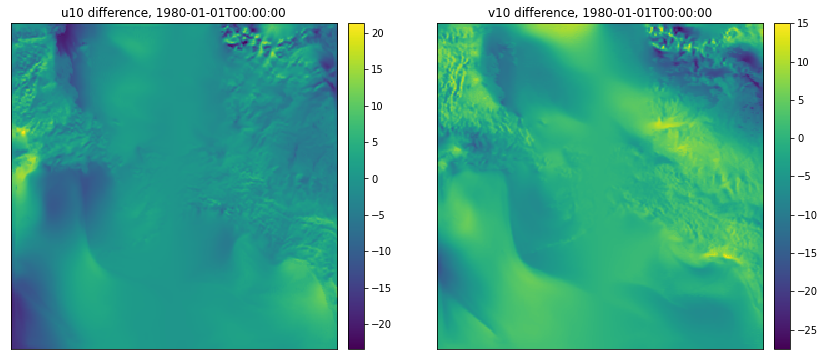

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# load truth dataset because it is small
truth_fp = "/workspace/Shared/Tech_Projects/wrf_data/project_data/wind-issue/truth_winds_1980-01-01_00.nc"
truth_ds = xr.load_dataset(truth_fp)

def plot_truth_difference(truth_ds, fig, var, subplot_code):
    # see note in cell above about keeping samples of incorrect data
    issue_fp = f"/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix/{var}_hourly_wrf_ERA-Interim_historical_1980.nc"
    t = "1980-01-01T00:00:00"
    with xr.open_dataset(issue_fp) as ds:
        issue_arr = ds[var].sel(time=t).values
    
    ax = fig.add_subplot(subplot_code)
    
    im = ax.imshow(
        np.flip(truth_ds[f"{var}e"].values, 0) - issue_arr, 
        interpolation="none"
    )
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.title.set_text(f"{var} difference, {t}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    plt.colorbar(im, cax=cax)
        
    return fig

fig = plt.figure(figsize=(14, 6))

fig = plot_truth_difference(truth_ds, fig, "u10", 121)
fig = plot_truth_difference(truth_ds, fig, "v10", 122)

Viola, the issue. The differences don't match the exact same image provided by Peter, but that could just be a result of the differences in visualization software being used.

(the coordinates printed below are given only to justify the verical flipping of the "truth" data set in the comparison)

In [8]:
# these snippets just demonstrate why the "truth" array needs to be flipped vertically to align properly.

# truth data
print("Truth data array bounds:")
print(f"lon start: {round(truth_ds.lon.values[0,0])};  end: {round(truth_ds.lon.values[0,-1])}")
print(f"lat start: {round(truth_ds.lat.values[0,0])};  end: {round(truth_ds.lat.values[-1,0])}\n")

# restacked data
print("Restacked data array bounds")
issue_fp = "/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix/u10_hourly_wrf_ERA-Interim_historical_1980.nc"
with xr.open_dataset(issue_fp) as ds: 
    print(f"lon start: {round(ds.xc.values[0])};  end: {round(ds.xc.values[-1])}")
    print(f"lat start: {round(ds.yc.values[0])};  end: {round(ds.yc.values[-1])}")

Truth data array bounds:
lon start: -178;  end: -126
lat start: 37;  end: 66

Restacked data array bounds
lon start: -2610000;  end: 2610000
lat start: -182425;  end: -5402425


#### Wind direction only?

Peter initially believed that this issue only affected wind directions derived from the components, not the speeds. This information was passed onto stakeholders that had already accessed the data. Test that this is the case:

In [9]:
# compute wind directions and speeds from truth data, 
# compare with wind directions / speeds from original data

import math

def convert_uv(uv):
    """Convert U,V wind components to speed and direction"""
    u, v = uv
    # compute wind direction
    angle = math.atan2(v, u) * 180 / math.pi
    if angle < 0:
        angle += 360
    # convert to degrees from North
    wd = 270 - angle
    if angle >= 270:
        wd += 360
    
    # compute wind speed
    ws = math.sqrt(u ** 2 + v ** 2) * 2.23694
    
    # return just wind speed
    #return round(ws, 3), round(wd, 3)
    return round(ws, 3)

def convert_arrays(u_arr, v_arr):
    """Convert """
    uv_list = [(u, v) for u, v in zip(u_arr.flatten(), v_arr.flatten())]
    return np.array([convert_uv(uv) for uv in uv_list]).reshape(262, 262)

t = "1980-01-01T00:00:00"
with xr.open_dataset(issue_fp) as ds:
    issue_u_arr = ds["u10"].sel(time=t).values
with xr.open_dataset(issue_fp.replace("u10", "v10")) as ds:
    issue_v_arr = ds["v10"].sel(time=t).values

truth_u_arr, truth_v_arr = [np.flip(truth_ds[var].values, 0) for var in ["u10e", "v10e"]]

truth_speeds = convert_arrays(truth_u_arr, truth_v_arr)
issue_speeds = convert_arrays(issue_u_arr, issue_v_arr)

print("Truth wind speeds match issue wind speeds: ", np.all(truth_speeds == issue_speeds))

Truth wind speeds match issue wind speeds:  False


Okay, so they don't match exactly, but I think this might be a rounding error. Are they within 0.01 m/s of each other?

In [10]:
print("Truth wind speeds are within 0.01 m/s of issue wind speeds: ", np.all(np.round(truth_speeds - issue_speeds, 2) == 0))

Truth wind speeds are within 0.01 m/s of issue wind speeds:  True


Yes, so it appears that the problem really does manifest only in the wind directions derived from the data.

### Processing pipeline

Some review of the code in the `snap_wrf_data_prep/` subdirectory of this repo suggests the following about its useage:

The raw WRF wind output data is first "stacked" to break out the files by year and variable, and then "improved" to provide a wholesome file/metadata structure. They are then copied to the AWS S3 bucket. 

#### Code

The `snap_wrf_data_prep` directory contains all of the code for processing the raw WRF wind output (all other variables as well) including the `pipeline` subdirectory which contains most of the code. The "stacking" step is done with `pipeline/stack_hourly_variable_year.py`. The codebase is designed to be run via slurm, and the `.slurm` scripts used to run the stacking script are made with `make_variable_sbatch_by_year.py`. Shell scripts, e.g. `run_allvars_dependency_full_erain.sh`, are used to call the relevant `.slurm` scripts. 

The "improvement" is done with `pipeline/improve_hourly_netcdf_strcutre.py`, which is called via slurm in `pipeline/wrap_run_improve_hourly_netcdf_structure.py`. 

Copying files to AWS is done with `wrap_run_move_wrf_aws_s3.py` which creates and uses scripts in `/workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm` to copy data in `/rcs/project_data/wrf_data/hourly_fix/` to AWS.

#### Directories

Stacked data created by `pipeline/stack_hourly_variable_year.py` is contained in an `hourly/` subdirectory, and improved data is contained in an `hourly_fix` directory. The paths to these directories are as follows:

* `/rcs/project_data/wrf_data/hourly/`: **stacked data**, raw WRF output with data broken out by year/variable
* `/rcs/project_data/wrf_data/hourly_fix/`: **improved data**, stacked data that has had its file structure improved

Other related directories:

* a `slurm_scripts` directrory that was originally in this repository, created in the scratch dir, for containing slurm scripts used in stacking
* `/workspace/Shared/Tech_Projects/wrf_data/project_data/aws_move_slurm`: slurm scripts used for moving files to AWS

**Note (KMR)** - I have also removed most of `/rcs/project_data/wrf_data/hourly` and kept some files in `/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly`. This was done using the following commands after all but a select few files had been removed.

```
mv /rcs/project_data/wrf_data/hourly/u*/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly
# (note, no other variables present that begin with "u")
mv /rcs/project_data/wrf_data/hourly/v/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly
mv /rcs/project_data/wrf_data/hourly/v10/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly
mv /rcs/project_data/wrf_data/hourly/vbot/* /rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly
```

## Exploration

This section explores the issue of improperly aligned winds present in the production data. Again, that is the data that *were* in `/rcs/project_data/wrf_data/hourly_fix/` and now exist in `/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix`.

### Test "stacking" step

The first step is to test stacking the raw output to see if the current stacking script produces the correct data.

First, move some sample files, including the one from which the truth data was derived, to `atlas_scratch` (not necessary, but part of the processing pipeline)

In [11]:
# copy 1980-01-01 WRF outputs to atlas_scratch
!mkdir -p /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980 && cp -n /storage01/pbieniek/erain/hourly/1980/*1980-01-01* /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980

# move template file that does not have permissions from atlas11
!cp -n /storage01/pbieniek/gfdl/hist/monthly/monthly_PCPT-gfdlh.nc /atlas_scratch/kmredilla/WRF/wind-issue

# WRF data copied
!ls /atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/1980/

WRFDS_d01.1980-01-01_00.nc  WRFDS_d01.1980-01-01_12.nc
WRFDS_d01.1980-01-01_01.nc  WRFDS_d01.1980-01-01_13.nc
WRFDS_d01.1980-01-01_02.nc  WRFDS_d01.1980-01-01_14.nc
WRFDS_d01.1980-01-01_03.nc  WRFDS_d01.1980-01-01_15.nc
WRFDS_d01.1980-01-01_04.nc  WRFDS_d01.1980-01-01_16.nc
WRFDS_d01.1980-01-01_05.nc  WRFDS_d01.1980-01-01_17.nc
WRFDS_d01.1980-01-01_06.nc  WRFDS_d01.1980-01-01_18.nc
WRFDS_d01.1980-01-01_07.nc  WRFDS_d01.1980-01-01_19.nc
WRFDS_d01.1980-01-01_08.nc  WRFDS_d01.1980-01-01_20.nc
WRFDS_d01.1980-01-01_09.nc  WRFDS_d01.1980-01-01_21.nc
WRFDS_d01.1980-01-01_10.nc  WRFDS_d01.1980-01-01_22.nc
WRFDS_d01.1980-01-01_11.nc  WRFDS_d01.1980-01-01_23.nc


Next, run a modification of the stacking script which can accept the (much) smaller amount of input data (a single day's worth) that matches the time period and variables provided in the truth data (U10 and V10, 1980-01-01):

In [13]:
# create test stacking directory
!mkdir -p /atlas_scratch/kmredilla/WRF/wind-issue/test-stack

import subprocess

test_u10_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-stack/u10_wrf_hourly_era_1980.nc"

command = [
    "python",
    "/workspace/UA/kmredilla/wrf_utils/snap_wrf_data_prep/wind-issue/stack_hourly_variable_year_winds_firstday.py",
    "-i", "/atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/",
    "-id", "/storage01/pbieniek/erain/hourly/",
    "-y", "1980",
    "-f", "/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf/docs/WRFDS_forecast_time_attr_erain.csv",
    "-v", "U10",
    "-o", test_u10_fp,
    "-t", "/atlas_scratch/kmredilla/WRF/wind-issue/monthly_PCPT-gfdlh.nc", # move if doesn't work
    "-a", "/workspace/Shared/Tech_Projects/wrf_data/project_data/ancillary_wrf_constants/geo_em.d01.nc",
]

subprocess.call(command)

0

Now, compare the truth data with the newly created restacked data:

In [14]:
test_u10e_ds = xr.load_dataset(test_u10_fp)

print("Truth data match manually stacked data:", np.all(test_u10e_ds.U10.values[0] == truth_ds.u10e.values))

Truth data match manually stacked data: True


So the restacking script appears to be working correctly. Now try for the other variable provided in the truth data, V10:

In [15]:
test_v10_fp = "/atlas_scratch/kmredilla/WRF/wind-issue/test-stack/v10_wrf_hourly_era_1980.nc"

command = [
    "python",
    "/workspace/UA/kmredilla/wrf_utils/snap_wrf_data_prep/wind-issue/stack_hourly_variable_year_winds_firstday.py",
    "-i", "/atlas_scratch/kmredilla/WRF/wind-issue/erain/hourly/",
    "-id", "/storage01/pbieniek/erain/hourly/",
    "-y", "1980",
    "-f", "/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf/docs/WRFDS_forecast_time_attr_erain.csv",
    "-v", "V10",
    "-o", test_v10_fp,
    "-t", "/atlas_scratch/kmredilla/WRF/wind-issue/monthly_PCPT-gfdlh.nc", # move if doesn't work
    "-a", "/workspace/Shared/Tech_Projects/wrf_data/project_data/ancillary_wrf_constants/geo_em.d01.nc",
]

subprocess.call(command)

0

In [16]:
test_v10e_ds = xr.load_dataset(test_v10_fp)

print("Truth data match manually stacked data:", np.all(test_v10e_ds.V10.values[0] == truth_ds.v10e.values))

Truth data match manually stacked data: True


Great. So the stacking script is producing correct results, which rules that out as the culprit. This suggests that the issue arises either in implementation of that script via slurm, or elsewhere in the processing, such as the "improve" script. 

Here is just a double check that the manually stacked data, which we know to be the truth data, do not match the original stacked data in `/rcs/project_data/wrf_data/hourly` (again, remaining samples moved from here to `/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly`). These should not match because the original stacked data should have the same underlying wind component values as the improved data in the `/rcs/project_data/wrf_data/hourly_fix` directory, which is already known to *not* match the truth data. Check:

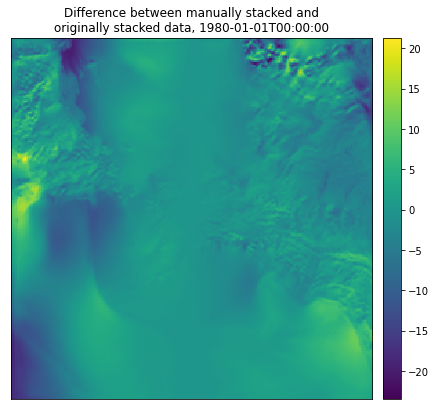

In [17]:
# original restacked U10 data that were in /rcs/project_data/wrf_data/hourly/u10/
hourly_fp = "/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly/U10_wrf_hourly_era_interim_1980.nc"
with xr.open_dataset(hourly_fp) as ds:
    hourly_arr = ds["U10"].sel(time="1980-01-01T00:00:00").values
    
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
im = ax.imshow(
    # flip just to have irl orientation (North at top)
    np.flip(test_u10e_ds.U10.values[0] - hourly_arr, 0), interpolation="none"
)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
t = "1980-01-01T00:00:00"
ax.title.set_text(f"Difference between manually stacked and\noriginally stacked data, {t}")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im, cax=cax)
plt.show()

So the originally stacked data is incorrect, which was expected because it should be a direct match to the "improved" data that were in `/rcs/project_data/wrf_data/hourly_fix`. Re-verify this:

In [20]:
# original restacked U10 data in /rcs/project_data/wrf_data/hourly/u10/
hourly_fix_fp = "/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly_fix/u10_hourly_wrf_ERA-Interim_historical_1980.nc"
with xr.open_dataset(hourly_fix_fp) as ds:
    hourly_fix_arr = ds["u10"].sel(time="1980-01-01T00:00:00").values
    
print("Originally stacked data match improved data:", np.all(hourly_fix_arr == np.flip(hourly_arr, 0)))

Originally stacked data match improved data: True


So the `improve_hourly_netcdf_structure.py` script was indeed used to improve the files in the `/rcs/project_data/wrf_data/hourly/`, writing the improved files to `/rcs/project_data/wrf_data/hourly_fix/` but not changing the underlying data. This rules out the `improve_hourly_netcdf_structure.py` as being the cause of the issue.

### Re-run stacking with Slurm

The final test will be to just re-run the stacking as designed with Slurm, to test whether this was just an issue of the final data not being run using this current codebase!

To do this, we first create relevant `.slurm` scripts that will execute the `stack_hourly_variable_year_winds.py` script, using the `processing_pipeline/make_variable_sbatch_by_year.py`. We will use a modified version of that script, `processing_pipeline/make_variable_sbatch_by_year_winds.py`, to create `.slurm` scripts for the wind variables only. 

Run the following in separate shell while working directory is the root of this repo:
```
export SLURM_EMAIL=kmredilla@alaska.edu
export BASE_DIR=/workspace/Shared/Tech_Projects/wrf_data/project_data
export SCRATCH_DIR=/atlas_scratch/kmredilla/WRF/wind-issue
export GFDL_RCP85_DIR=/storage01/rtladerjr/hourly
export CCSM_RCP85_DIR=/storage01/pbieniek/ccsm/rcp85/hourly
export GFDL_HIST_DIR=/storage01/pbieniek/gfdl/hist/hourly
export CCSM_HIST_DIR=/storage01/pbieniek/ccsm/hist/hourly
export ERA_DIR=/storage01/pbieniek/erain/hourly
    
pipenv run python snap_wrf_data_prep/pipeline/make_variable_sbatch_by_year.py -v "U V U10 V10 UBOT VBOT"
```

See that slurm scripts were created:


In [29]:
!ls /atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/*.slurm

/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/U10_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/U10_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/U_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/U_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/UBOT_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/UBOT_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/V10_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/V10_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/V_1970_ccsm_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/V_1970_gfdl_hist.slurm
/atlas_scratch/kmredilla/WRF/wind-issue/stacked/slurm_scripts/1970/VBOT_1970_ccsm_hist

Now, use a modified version of the `snap_wrf_data_prep/pipeline/run_allvars_dependency_full_erain.sh`, called `snap_wrf_data_prep/winds-issue/run_winds_dependency_full_erain.sh`, to submit the jobs. This takes a while to run. When the 1980 data has completed, we can check that these match the truth data. 

**Note (KMR)** - the data output here were copied off of the scratch space via:

```
export OUTPUT_DIR=/rcs/project_data/wrf_data/wind-issue
export SCRATCH_DIR=/atlas_scratch/kmredilla/WRF/wind-issue/
pipenv run python snap_wrf_data_prep/pipeline/cleanup_stacked_scratch.py
```

We can check that these data match the truth data:

In [31]:
test_slurm_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_erain_1980.nc"
with xr.open_dataset(test_slurm_fp) as ds:
    restacked_u10e = ds.U10.sel(time="1980-01-01T00:00:00").values
    
print("Newly restacked data match improved data:", np.all(truth_ds.u10e.values == restacked_u10e))

Newly restacked data match improved data: True


Okay, as expected, the `slurm` process is not the issue. 

## Conclusion

The fact that the codebase produces the correct output data suggests that the issue was caused by a logistical error. Perhaps the most recent code was just never run to completion, or it may have been run and the resulting files were not copied off of the scratch dir, etc.

This means stacking for all models and scenarios has to be re-run. 

## Re-run stacking

So, I've created modified versions of the `snap_wrf_data_prep/pipeline/run_allvars_dependency_full_<model/scenario>.sh` script specific to the winds variables for each model and scenario, saved as `snap_wrf_data_prep/winds-issue/run_winds_dependency_full<model/scenario>.sh`.

...

These have all run to completion, and the completed files have been copied off scratch space to `/rcs/project_data/wrf_data/wind-issue/hourly`. We should check whether these newly restacked data are different from the original stacked data for some other models / scenarios:

Compare these for NCAR CCSM4 historical:

In [35]:
def compare_restacked_data(restacked_fp, original_fp, var, year):
    with xr.open_dataset(restacked_fp) as ds:
        restacked_arr = ds[var].sel(time=f"{year}-01-01T00:00:00").values

    with xr.open_dataset(original_fp) as ds:
        original_arr = ds[var].sel(time=f"{year}-01-01T00:00:00").values

    print("Newly restacked data match original restacked data:", np.all(original_arr == restacked_arr))


restacked_ccsm_2005_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_hist_2005.nc"
original_ccsm_2005_fp = "/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly/U10_wrf_hourly_ccsm_hist_2005.nc"

compare_restacked_data(restacked_ccsm_2005_fp, original_ccsm_2005_fp, "U10", 2005)

Newly restacked data match original restacked data: False


And for GFDL CM3 historical:

In [36]:
restacked_gfdl_2005_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_gfdl_hist_2005.nc"
original_gfdl_2005_fp = "/rcs/project_data/wrf_data/wind-issue/incorrect_samples/hourly/U10_wrf_hourly_gfdl_hist_2005.nc"

compare_restacked_data(restacked_gfdl_2005_fp, original_gfdl_2005_fp, "U10", 2005)

Newly restacked data match original restacked data: False


As expected, these don't match. 

**Note (KMR)** - during the restacking, I noticed another path that includes some originally stacked data: `/rcs/project_data/WRF_DATA_SEP2019`.

In [44]:
!ls /rcs/project_data/WRF_DATA_SEP2019/u10 | head -5

U10_wrf_hourly_ccsm_hist_1970.nc
U10_wrf_hourly_ccsm_rcp85_2005.nc
U10_wrf_hourly_ccsm_rcp85_2006.nc
U10_wrf_hourly_ccsm_rcp85_2007.nc
U10_wrf_hourly_ccsm_rcp85_2008.nc


I checked whether these match the newly restacked data for those that had completed for a set of files:

In [40]:
restacked_ccsm_2006_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"
original_ccsm_2006_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc"

compare_restacked_data(restacked_ccsm_2006_fp, original_ccsm_2006_fp, "U10", 2006)

Newly restacked data match original restacked data: True


In [42]:
# 2010 CCSM U10
restacked_ccsm_2010_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2010.nc"
original_ccsm_2010_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2010.nc"

compare_restacked_data(restacked_ccsm_2010_fp, original_ccsm_2010_fp, "U10", 2010)

Newly restacked data match original restacked data: True


In [45]:
# 2030 CCSM U10
restacked_ccsm_2030_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2030.nc"
original_ccsm_2030_fp = "/rcs/project_data/WRF_DATA_SEP2019/u10/U10_wrf_hourly_ccsm_rcp85_2030.nc"

compare_restacked_data(restacked_ccsm_2030_fp, original_ccsm_2030_fp, "U10", 2030)

Newly restacked data match original restacked data: True


In [46]:
# 2021 CCSM V10
restacked_ccsm_2021_fp = "/rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_ccsm_rcp85_2021.nc"
original_ccsm_2021_fp = "/rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_ccsm_rcp85_2021.nc"

compare_restacked_data(restacked_ccsm_2021_fp, original_ccsm_2021_fp, "V10", 2021)

Newly restacked data match original restacked data: True


Okay. This means the restacking has to be done for most of the future years, but not all. I temporarily modified the `STARTYEAR` in the relevant `run_winds_dependency_full_<model/scenario>.sh` scripts to start from a pre-specified year to expedite the process of restacking.

### Move off scratch space

While the re-stacking was running, we were hitting storage limitations on the scratch space. The `snap_wrf_data_prep/pipeline/move_stacked_from_scratch.py` script was developed and run during re-stacking to ensure completed files were moved off of the scratch space. The `pipeline/cleanup_stacked_scratch.py` was created to remove any files from `$SCRATCH_DIR` that were already present in the `$OUTPUT_DIR`. This would have occured due to copying early on in the re-stacking process via command line to free up space.

#### linking existing correctly stacked files

**Note (KMR)** - Because some of the correctly stacked data had already been produced - data stacked using the most recent version of the code here - and we only needed to re-stack a subset of the model/years, this of course results in two different locations for this correctly stacked data: the `/rcs/project_data/WRF_DATA_SEP2019` and the new `/rcs/project_data/wind-issue/hourly`. The following cell links to the previously restacked data from within the newly re-stacked directory for testing purposes. I opted for this approach instead of moving files for historical purposes of understanding what was done to rectify this issue. 

In [9]:
# create symlinks for all files that were already restacked before these efforts
from pathlib import Path

new_restack_dir = Path("/rcs/project_data/wrf_data/wind-issue/hourly")
old_restack_dir = Path("/rcs/project_data/WRF_DATA_SEP2019")

def create_symlinks(in_dir, out_dir):
    """Create symlinks in out_dir for files in 
    in_dir that are not present in out_dir
    """
    present_fns = [fp.name for fp in out_dir.glob("*")]
    out_fps = [out_dir.joinpath(fp.name) for fp in in_dir.glob("*") if fp.name not in present_fns]
    
    return [fp.symlink_to(in_dir.joinpath(fp.name)) for fp in out_fps]

out = [
    create_symlinks(old_restack_dir.joinpath(var), new_restack_dir.joinpath(var))
    for var in ["u", "u10", "ubot", "v", "v10", "vbot"]
]

In [47]:
# show some files that have been sym-linked
!ls -l /rcs/project_data/wrf_data/wind-issue/hourly/v10/*201[7-9]*

lrwxrwxrwx. 1 snap-smb dyndown 72 Apr 14 12:09 /rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_ccsm_rcp85_2017.nc -> /rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_ccsm_rcp85_2017.nc
lrwxrwxrwx. 1 snap-smb dyndown 72 Apr 14 12:09 /rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_ccsm_rcp85_2018.nc -> /rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_ccsm_rcp85_2018.nc
lrwxrwxrwx. 1 snap-smb dyndown 72 Apr 14 12:09 /rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_ccsm_rcp85_2019.nc -> /rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_ccsm_rcp85_2019.nc
lrwxrwxrwx. 1 snap-smb dyndown 72 Apr 14 12:09 /rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_gfdl_rcp85_2017.nc -> /rcs/project_data/WRF_DATA_SEP2019/v10/V10_wrf_hourly_gfdl_rcp85_2017.nc
lrwxrwxrwx. 1 snap-smb dyndown 72 Apr 14 12:09 /rcs/project_data/wrf_data/wind-issue/hourly/v10/V10_wrf_hourly_gfdl_rcp85_2018.nc -> /rcs/project_data/WRF_DATA_SEP2019/v10/V10_

## Re-run file structure improvement

Next, re-run the file improvement. This is done in a separate environment by calling the `snap_wrf_data_prep/pipeline/wrap_run_improve_hourly_netcdf_structure.py` script, with the `OUTPUT_DIR` env var set to `/rcs/project_data/wrf_data/wind-issue/`. Outputs are then written to `/rcs/project_data/wrf_data/wind-issue/hourly_fix`.

## QA/QC

Perform QA/QC on the repaired wind data.

### Quality assurance

#### All years present

There were some issues during re-processing that required some piecewise efforts. Verify that no years were missed for any variables in `/rcs/project_data/wrf_data/wind-issue/hourly_fix`. 

##### Years key

ERA-Interim (historical): 1979-2015  
NCAR-CCSM4 historical: 1970-2005  
GFDL-CM3 historical: 1970-2006  
NCAR-CCSM4 RCP85: 2005-2100   
GFDL-CM3 RCP85: 2006-2100  

In [51]:
fix_dir = Path("/rcs/project_data/wrf_data/wind-issue/hourly_fix")

models = ["ERA-Interim", "NCAR*historical", "GFDL*historical", "NCAR*rcp85", "GFDL*rcp85"]
year_ranges = [np.arange(1979, 2016), np.arange(1970, 2006), np.arange(1970, 2007), np.arange(2005, 2101), np.arange(2006, 2101)]

results_di = {}
for var in ["u", "v", "u10", "v10", "ubot", "vbot"]:
    var_results_di = {}
    for model, year_range in zip(models, year_ranges):
        fps = sorted(list(fix_dir.glob(f"{var}/*{model}*")))
        fp_years = [int(str(fp).split("_")[-1][:-3]) for fp in fps]
        extra_years = list(set(fp_years) - set(year_range))
        missing_years = list(set(year_range) - set(fp_years))
        var_results_di[model] = {"extra": extra_years, "missing": missing_years}
    results_di[var] = var_results_di

results = []
for var in results_di:
    for model in results_di[var]:
        for status in results_di[var][model]:
            results.append(results_di[var][model][status] == [])
            
print("No missing or extra years found:", np.all(results))

No missing or extra years found: True


#### All files open with `xarray`; verify file structure and metadata

Open files and read metadata with both `xarray` in Python. Verify consistent file structure and metadata.

Reading the metadata and file structure also ensures that the file opens properly. 

With `xarray`, ensure that all files have the same structure. I.e., with a file open as `ds`, check that the dimensions (`ds.xc`, `ds.yc`, `ds.time`) are consistent across files and have the same shape (e.g. with the `ds.dims` attribute)(note there is an extra dimension, `plev`, for u and v variables); check that global and coordinate variable attributes match where they should.

In [77]:
from multiprocessing import Pool
import time

def get_meta(fp):
    with xr.open_dataset(fp) as ds:
        global_meta = ds.attrs.copy()
        for key in ["creation_date", "system", "grib_source", "reference_time", "NCL_Version"]:
            del global_meta[key]

        var_meta = {}
        for var in list(ds.variables)[:3]:
            var_meta[var] = ds[var].attrs.copy()
            if var not in ["xc", "yc"]:
                del var_meta[var]["long_name"]
                var_meta["var"] = var_meta.pop(var)

        spatial_ok = [ds.dims[coord] == 262 for coord in ["xc", "yc"]]
        time_ok = ds.dims["time"] > 8000
    spatial_ok.append(time_ok)
    var_meta["dims_ok"] = np.all(spatial_ok)
    
    return {"global_meta": global_meta, "var_meta": var_meta, "filepath": fp}


all_fps = list(fix_dir.glob("*/*.nc"))

truth_meta = get_meta(all_fps[0])

tic = time.perf_counter()

with Pool(30) as pool:
    all_meta = pool.map(get_meta, all_fps)

results = []
for file_meta in all_meta:
    global_result = truth_meta["global_meta"] == file_meta["global_meta"]
    var_result = truth_meta["var_meta"] == file_meta["var_meta"]
    result = global_result & var_result
    if not result:
        # check if not a match due to "dims_ok" test. 
        # dims_ok will never be true for GFDL historical 2006 or 
        # ERA-Interim historical 2015.
        if global_result:
            if not file_meta["var_meta"]["dims_ok"]:
                suffixes = ["GFDL-CM3_historical_2006.nc", "ERA-Interim_historical_2015.nc"]
                if any([str(file_meta["filepath"]).endswith(suffix) for suffix in suffixes]):
                    result = True
    results.append(result)

print("All metadata match:", np.all(results))
print(f"Time elapsed: {round(time.perf_counter() - tic, 1)}s")

All metadata match: True
Time elapsed: 22.9s


Test that a file opens with other programs as well:

*GDAL*

Output from `gdalinfo` is verbose because of all the bands, so assign the output to a variable and print the beginning.

In [69]:
output = subprocess.check_output(["gdalinfo", "-nomd", "/rcs/project_data/wrf_data/wind-issue/hourly_fix/u10/u10_hourly_wrf_GFDL-CM3_rcp85_2034.nc"])
print(output[:593].decode("utf-8"))

Driver: netCDF/Network Common Data Format
Files: /rcs/project_data/wrf_data/wind-issue/hourly_fix/u10/u10_hourly_wrf_GFDL-CM3_rcp85_2034.nc
Size is 262, 262
Origin = (-2620000.000000000000000,-172425.477371663786471)
Pixel Size = (20000.000000000000000,-20000.000000000000000)
Corner Coordinates:
Upper Left  (-2620000.000, -172425.477) 
Lower Left  (-2620000.000,-5412425.477) 
Upper Right ( 2620000.000, -172425.477) 
Lower Right ( 2620000.000,-5412425.477) 
Center      (       0.000,-2792425.477) 
Band 1 Block=30x30 Type=Float32, ColorInterp=Undefined
  NoData Value=nan
  Unit Type: m/s



*ncdump*

In [70]:
!ncdump -h /rcs/project_data/wrf_data/wind-issue/hourly_fix/v10/v10_hourly_wrf_NCAR-CCSM4_historical_2003.nc

netcdf v10_hourly_wrf_NCAR-CCSM4_historical_2003 {
dimensions:
	time = 8760 ;
	yc = 262 ;
	xc = 262 ;
variables:
	float v10(time, yc, xc) ;
		v10:_FillValue = NaNf ;
		v10:long_name = "v-component of wind at 10m height" ;
		v10:units = "m/s" ;
		v10:coordinates_ = "xc yc" ;
		v10:temporal_resampling = "None: these data represent hourly outputs from wrf dynamical downscaling." ;
	double xc(xc) ;
		xc:_FillValue = NaN ;
		xc:grid_mapping_name = "polar_stereographic" ;
		xc:straight_vertical_longitude_from_pole = -152. ;
		xc:latitude_of_projection_origin = 90. ;
		xc:standard_parallel = 64. ;
		xc:false_easting = 0LL ;
		xc:false_northing = 0LL ;
		xc:crs_wkt = "PROJCS[\"unnamed\",GEOGCS[\"unnamed ellipse\",DATUM[\"unknown\",SPHEROID[\"unnamed\",6370000,0]],PRIMEM[\"Greenwich\",0],                                UNIT[\"degree\",0.0174532925199433]],PROJECTION[\"Polar_Stereographic\"],PARAMETER[\"latitude_of_origin\",64],PARAMETER[\"central_meridian\",-152],                               

Check that files conform to CF convention (they don't and weren't designed to, but this is part of the QA/QC process)

In [71]:
!compliance-checker --test=cf:1.6 /rcs/project_data/wrf_data/wind-issue/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_historical_1978.nc

Running Compliance Checker on the datasets from: ['/rcs/project_data/wrf_data/wind-issue/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_historical_1978.nc']


--------------------------------------------------------------------------------
                         IOOS Compliance Checker Report                         
                                     cf:1.6                                     
       http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html       
--------------------------------------------------------------------------------
                               Corrective Actions                               
u10_hourly_wrf_NCAR-CCSM4_historical_1978.nc has 7 potential issues


                                     Errors                                     
--------------------------------------------------------------------------------
§2.2 Data Types
* The variable time failed because the datatype is int64

§3.3 Standard Name
* Attribute long_name or/and standar

### Quality control

#### Match with truth data

Verify that all values match truth for what is available in the truth dataset.

In [28]:
fix_dir = Path("/rcs/project_data/wrf_data/wind-issue/hourly_fix")

ts = "1980-01-01 00:00:00"
with xr.open_dataset(list(fix_dir.glob("u10/*ERA*1980*"))[0]) as ds:
    u10_match = np.array_equal(np.flip(ds["u10"].sel(time=ts).values, 0), truth_ds.u10e.values)
    
with xr.open_dataset(list(fix_dir.glob("v10/*ERA*1980*"))[0]) as ds:
    v10_match = np.array_equal(np.flip(ds["v10"].sel(time=ts).values, 0), truth_ds.v10e.values)
    
print("Newly improved data match the truth data:", np.all([u10_match, v10_match]))

Newly improved data match the truth data: True


#### Reasonable values with histograms

Verify that all values appear reasonable by plotting for a manageable subset of files. Do this by plotting histograms.

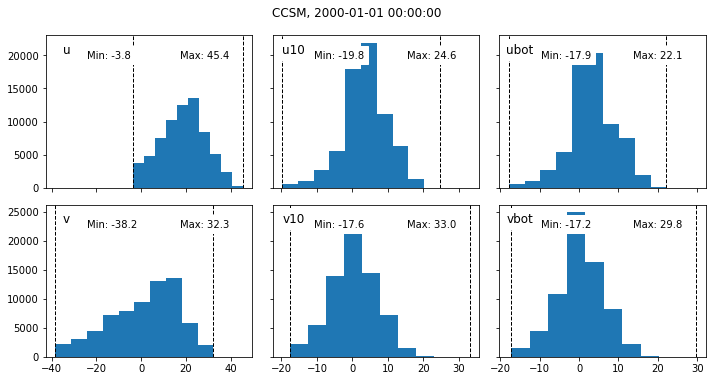

In [80]:
def plot_winds_histograms(fix_dir, model="CCSM", ts="2000-01-01 00:00:00"):
    """For a given time slice, plot histograms of all variables"""
    year = ts[:4]
    fig, ax = plt.subplots(2, 3, figsize=(10, 5), sharex="col", sharey="row")
    for i, component in zip([0, 1], ["u", "v"]):
        for j, suffix in zip([0, 1, 2], ["", "10", "bot"]):
            var = component + suffix
            fp = list(fix_dir.glob(f"{var}/*{model}*{year}*"))[0]
            with xr.open_dataset(fp) as ds:
                if suffix == "":
                    arr = ds[var].sel(time=ts, plev=50).values.flatten()
                else:
                    arr = ds[var].sel(time=ts).values.flatten()
                    
            ax[i, j].hist(arr)
            ax[i, j].annotate(
                var, 
                xy=(0.1, 0.85), 
                xytext=(0, 5),
                xycoords='axes fraction', 
                textcoords='offset points',
                size='large', 
                ha='center', 
                va='baseline',
                backgroundcolor="white",
            )
            # min and max lines
            ax[i, j].axvline(arr.min(), color='k', linestyle='dashed', linewidth=1)
            ax[i, j].axvline(arr.max(), color='k', linestyle='dashed', linewidth=1)
            ax[i, j].annotate(
                'Min: {:.1f}'.format(arr.min()), 
                xy=(0.2, 0.85), 
                xycoords='axes fraction',
                backgroundcolor="white",
            )
            ax[i, j].annotate(
                'Max: {:.1f}'.format(arr.max()), 
                xy=(0.65, 0.85), 
                xycoords='axes fraction',
                backgroundcolor="white",
            )
            
    fig.tight_layout()
    fig.suptitle(f"{model}, {ts}", y=1.05)
    plt.show()
    
    return fig


times = [
    "2000-01-01 00:00:00", 
    "2001-11-15 00:00:00", 
    "2004-11-09 00:00:00",
    "2017-03-17 09:00:00",
    "2021-04-19 07:00:00",
]

fig = plot_winds_histograms(fix_dir, "CCSM", times[0])

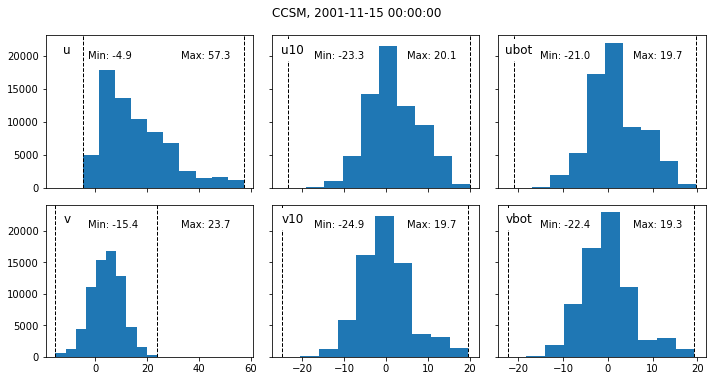

In [81]:
fig = plot_winds_histograms(fix_dir, "CCSM", times[1])

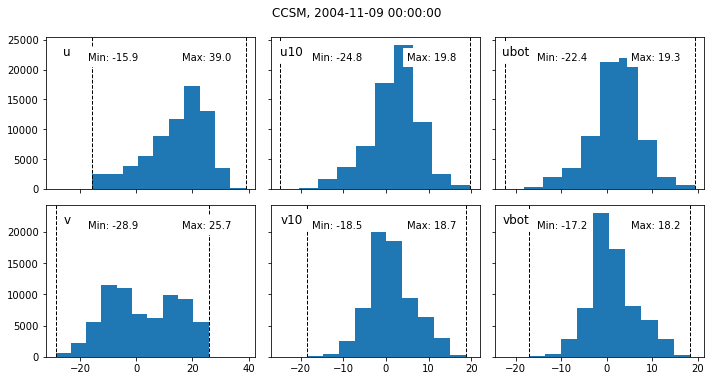

In [82]:
fig = plot_winds_histograms(fix_dir, "CCSM", times[2])

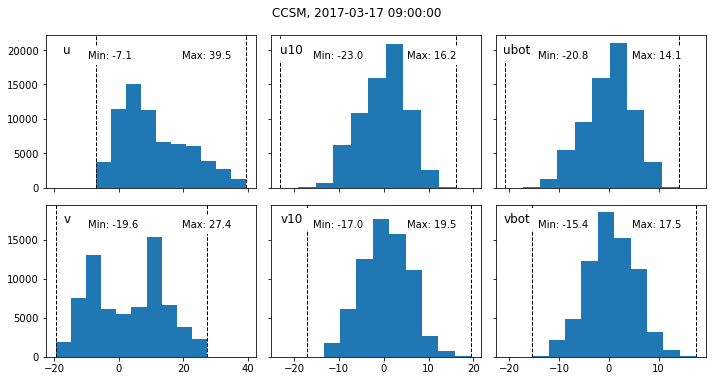

In [83]:
fig = plot_winds_histograms(fix_dir, "CCSM", times[3])

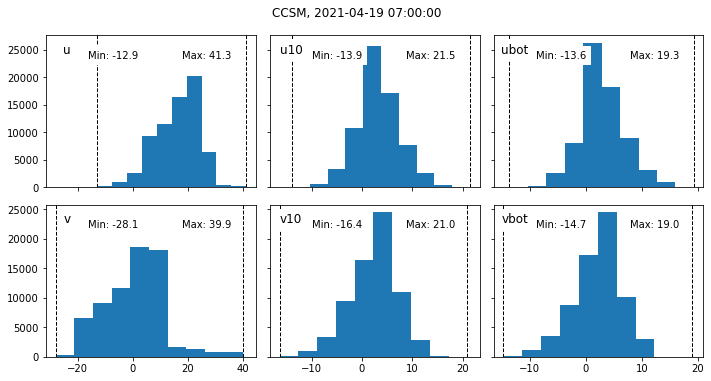

In [84]:
fig = plot_winds_histograms(fix_dir, "CCSM", times[4])

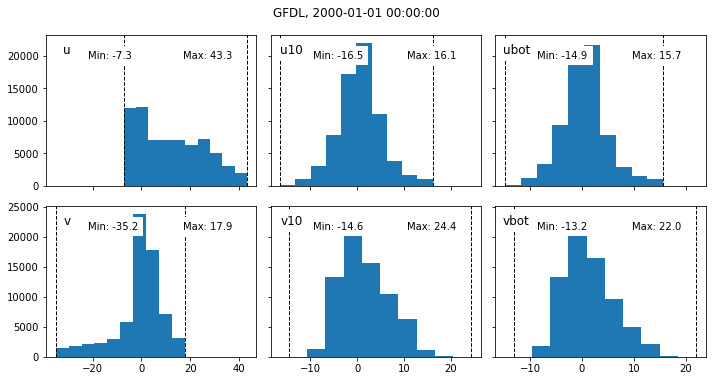

In [85]:
fig = plot_winds_histograms(fix_dir, "GFDL", times[0])

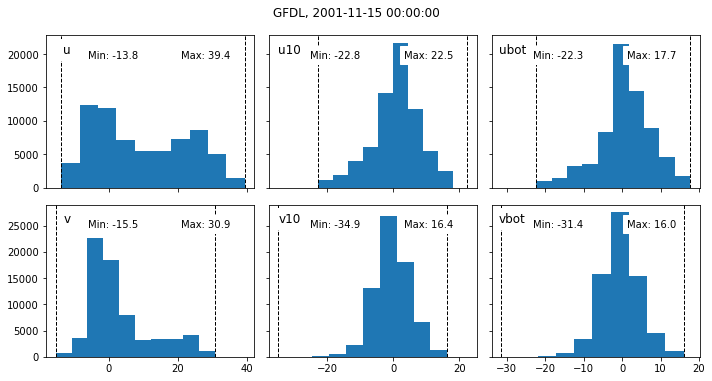

In [86]:
fig = plot_winds_histograms(fix_dir, "GFDL", times[1])

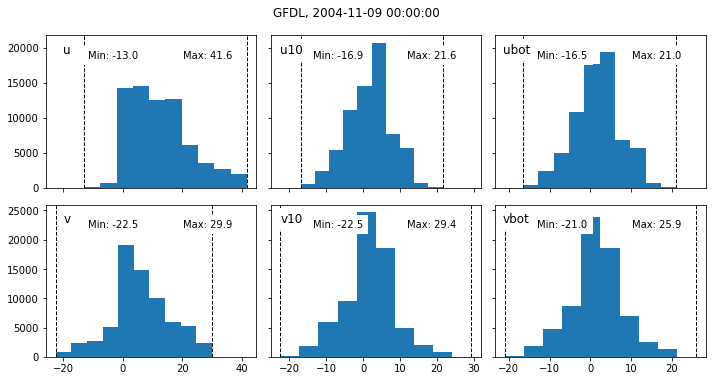

In [87]:
fig = plot_winds_histograms(fix_dir, "GFDL", times[2])

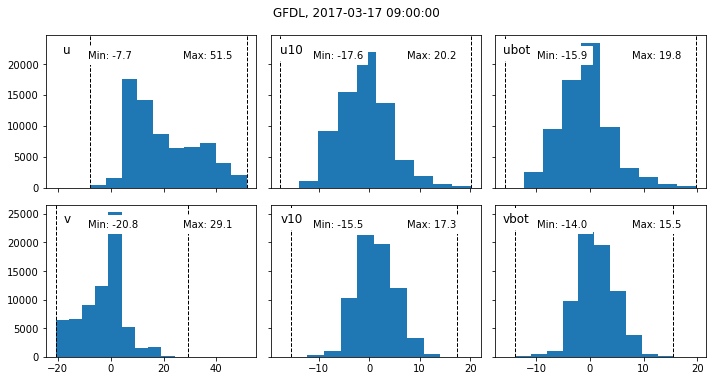

In [88]:
fig = plot_winds_histograms(fix_dir, "GFDL", times[3])

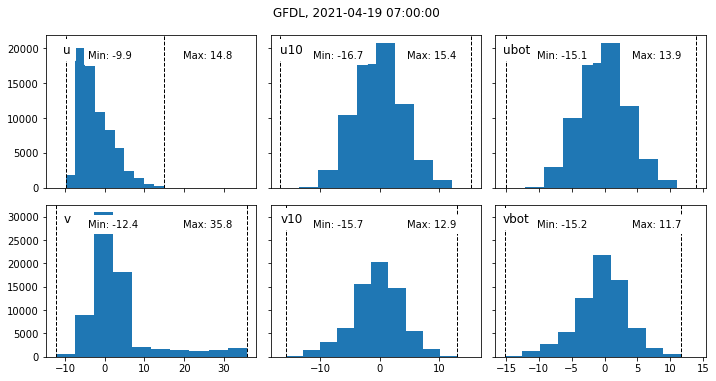

In [89]:
fig = plot_winds_histograms(fix_dir, "GFDL", times[4])

#### Geospatial reference checks

Plot the georeferenced data for a sample of files, and display the following locations using the specifed coordinates:

Juneau: 58.3019° N, 134.4197° W  
Anchorage: 61.2181° N, 149.9003° W  
Fairbanks: 64.8378° N, 147.7164° W  
Utqiaġvik: 71.2906° N, 156.7886° W  

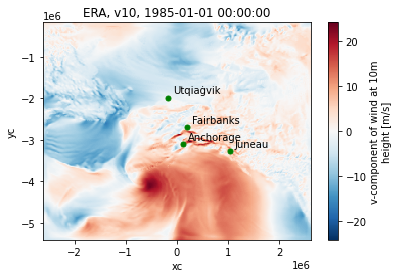

In [25]:
from pyproj import Transformer, crs

def plot_raster_with_locations(variable, model, year):
    ts = f"{year}-01-01 00:00:00"
    with xr.open_dataset(list(fix_dir.glob(f"{variable}/*{model}*{year}*"))[0]) as ds:
        fig = ds[variable].sel(time=ts).plot()

    wrf_crs = crs.CRS(ds.attrs["crs_wkt"])
    transformer = Transformer.from_crs(4326, wrf_crs, always_xy=True)
    points = [(-134.4197, 58.3019), (-149.9003, 61.2181), (-147.7164, 64.8278), (-156.7886, 71.2906)]
    locations = ["Juneau", "Anchorage", "Fairbanks", "Utqiaġvik"]
    for pt, location in zip(transformer.itransform(points), locations): 
        plt.plot(*pt, markersize=10, marker=".", color="green")
        plt.text(pt[0] + 1e5, pt[1] + 1e5, location)
        plt.title(f"{model}, {variable}, {ts}")
        
plot_raster_with_locations("v10", "ERA", "1985")

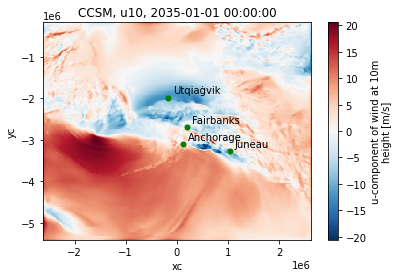

In [26]:
plot_raster_with_locations("u10", "CCSM", "2035")

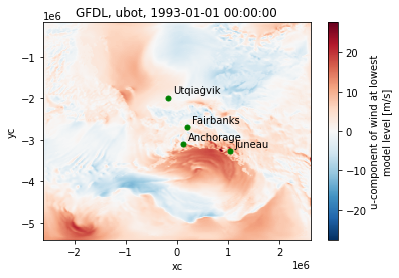

In [27]:
plot_raster_with_locations("ubot", "GFDL", "1993")